### 0. import dependencies

In [1]:
import torch
from torch import optim
import torch.nn.functional as F
from torchmetrics import AUROC

from models.PropertyRegressors import PropertyRegressors

from datasets.get_fingerprints import get_fingerprints
from datasets.get_molecular_descriptors import get_molecular_descriptors
from datasets.get_chembert2as import get_chembert2as
from datasets.get_molformers import get_molformers
from datasets.create_data_loaders import create_data_loaders

from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from torchmetrics import AUROC
import numpy as np

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f'device is {device}')

/opt/miniconda3/envs/midexam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device is cpu


### 1. get features and embeddings

In [2]:
descriptors = get_molecular_descriptors(task='classification').to(device)
print(f"descriptor tensor shape: {descriptors.shape}")  # [num_samples, 210]

fingerprints, label_tensor = get_fingerprints(task='classification')
print(f"fingerprint tensor shape: {fingerprints.shape}")  # [num_samples, 2048]

chembert2as = get_chembert2as(task='classification').to(device)
print(f"chembert2a tensor shape: {chembert2as.shape}")  # [num_samples, 600]

molformers = get_molformers(task='classification').to(device)
print(f"molformers tensor shape: {molformers.shape}")  # [num_samples, 768]

get_molecular_descriptors: 100%|██████████| 7807/7807 [01:34<00:00, 82.81it/s] 


descriptor tensor shape: torch.Size([7807, 210])


get_fingerprints: 100%|██████████| 7807/7807 [00:01<00:00, 6094.31it/s]


fingerprint tensor shape: torch.Size([7807, 2048])


get_chembert2as: 100%|██████████| 7807/7807 [00:24<00:00, 324.78it/s]


chembert2a tensor shape: torch.Size([7807, 600])


get_molformers: 100%|██████████| 7807/7807 [03:12<00:00, 40.66it/s]

molformers tensor shape: torch.Size([7807, 768])


### 2. set train and val loaders

In [25]:
train_loader, val_loader = create_data_loaders(
    descriptors=descriptors,
    fingerprints=fingerprints,
    chembert2as=chembert2as,
    molformers=molformers,
    labels=label_tensor,
    batch_size=2048
)

num_epochs = 500

### 3. set and train the model

In [26]:
# Initialize model, optimizer, and loss function
model = PropertyRegressors(128, 1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=1, eta_min=1e-6, last_epoch=-1)
criterion = torch.nn.BCEWithLogitsLoss()

# Training loop
model.train()
epoch_loss = 0.0
epoch_val_loss = 0.0

auroc = AUROC(task="binary")

train_losses = []
val_losses = []

train_aurocs = []
val_aurocs = []

train_lambdas = []

epoch_val_predictions = []
epoch_val_labels = []

for _ in tqdm(range(num_epochs), 'Epoch'):
    for batch in train_loader:
        optimizer.zero_grad()

        desc = batch['descriptors']          # Shape: [batch_size, 210]
        fps = batch['fingerprints']          # Shape: [batch_size, 2048]
        chembert = batch['chembert2as']      # Shape: [batch_size, 600]
        molformer = batch['molformers']      # Shape: [batch_size, 768]
        labels = batch['label'].view(-1,1)   # Shape: [batch_size, 1]

        desc = torch.zeros_like(desc)
        fps = torch.zeros_like(fps)
        # chembert = torch.zeros_like(chembert)
        # molformer = torch.zeros_like(molformer)

        # Forward pass
        predictions, lambdas = model(desc, fps, chembert, molformer)
        # print(predictions)
        # Calculate loss
        loss = criterion(predictions, labels)
        auroc(predictions, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Print epoch results
    scheduler.step()
    avg_epoch_loss = epoch_loss / len(train_loader)
    report_lambdas = list(lambdas.detach().cpu())

    train_losses.append(avg_epoch_loss)
    train_aurocs.append(auroc.compute())
    train_lambdas.append(report_lambdas)
    # print(f'Epoch {epoch} completed. Average loss: {avg_epoch_loss:.4f}. AUROC: {auroc.compute():.4f}. Lambdas: {report_lambdas}')
    epoch_loss = 0.0
    auroc.reset()

    with torch.no_grad():
        for batch in val_loader:
            optimizer.zero_grad()

            desc = batch['descriptors']          # Shape: [batch_size, 210]
            fps = batch['fingerprints']          # Shape: [batch_size, 2048]
            chembert = batch['chembert2as']      # Shape: [batch_size, 600]
            molformer = batch['molformers']      # Shape: [batch_size, 768]
            val_labels = batch['label'].view(-1,1)  # Shape: [batch_size, 1]

            desc = torch.zeros_like(desc)
            fps = torch.zeros_like(fps)
            # chembert = torch.zeros_like(chembert)
            # molformer = torch.zeros_like(molformer)

            # Forward pass
            val_predictions, val_lambdas = model(desc, fps, chembert, molformer)
            # print(predictions)
            # Calculate loss
            loss = criterion(val_predictions, val_labels)
            auroc(val_predictions, val_labels)

            # Backward pass and optimization

            epoch_val_loss += loss.item()
            epoch_val_predictions.append(val_predictions)
            epoch_val_labels.append(val_labels)
        # Print epoch results
        avg_epoch_loss = epoch_val_loss / len(val_loader)
        report_lambdas = list(lambdas.detach().cpu())
        # print(f'Epoch {epoch} completed. Average loss: {avg_epoch_loss:.4f}. AUROC: {auroc.compute():.4f}. (Val)')
        # print(lambdas)
        val_losses.append(avg_epoch_loss)
        val_aurocs.append(auroc.compute())
        epoch_val_loss = 0.0
        auroc.reset()
print(lambdas)


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 100%|██████████| 500/500 [02:03<00:00,  4.04it/s]

tensor([[0.2352],
        [0.2372],
        [0.2626],
        [0.2650]], grad_fn=<SoftmaxBackward0>)


### 4. visualize the learning process and check the best performance

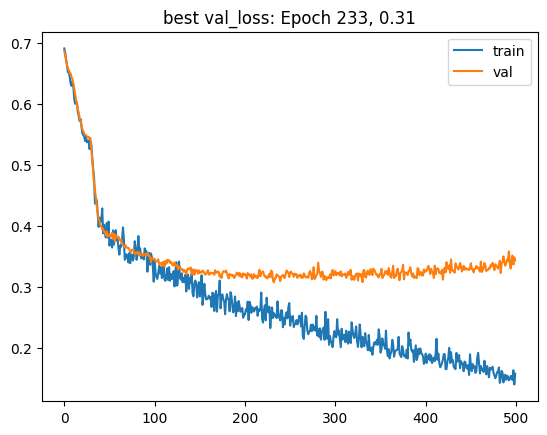

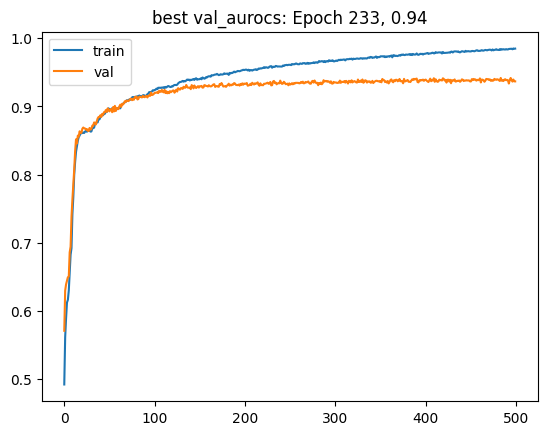

In [27]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
val_loss_best_epoch = np.argmin(val_losses)
plt.title(f'best val_loss: Epoch {val_loss_best_epoch+1}, {val_losses[val_loss_best_epoch]:.2f}')
plt.legend()
plt.show()

plt.plot(train_aurocs, label='train')
plt.plot(val_aurocs, label='val')
val_aurocs_best_epoch = np.argmin(val_losses)
plt.title(f'best val_aurocs: Epoch {val_aurocs_best_epoch+1}, {val_aurocs[val_aurocs_best_epoch]:.2f}')
plt.legend()
plt.show()

### 5. visualize the predicted distributions by class at the best performing epoch

Best val AUROC: 0.937


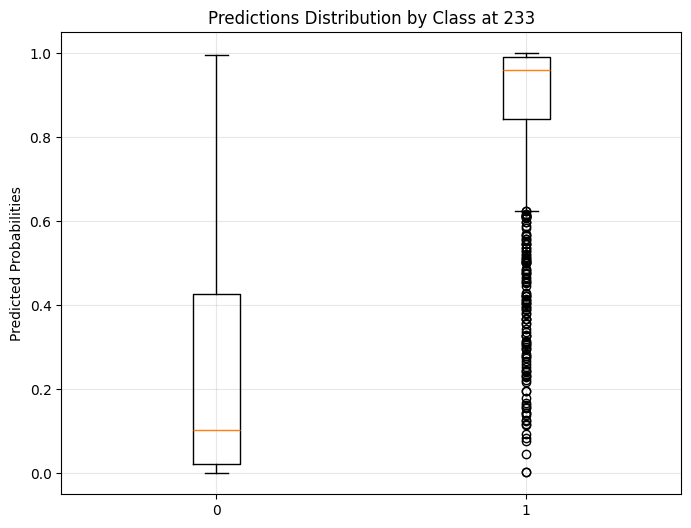

In [30]:
# Reset and compute AUROC
print(f"Best val AUROC: {val_aurocs[val_aurocs_best_epoch]:.3f}")

# Convert to numpy for plotting
L = epoch_val_labels[val_aurocs_best_epoch].view(-1,1).detach().cpu().numpy()
P = epoch_val_predictions[val_aurocs_best_epoch].sigmoid().detach().cpu().numpy()

# Create box plot
plt.figure(figsize=(8, 6))
plt.boxplot([P[L.flatten() == 0].flatten(), P[L.flatten() == 1].flatten()], 
            labels=['0', '1'])
plt.ylabel('Predicted Probabilities')
plt.title(f'Predictions Distribution by Class at {val_aurocs_best_epoch+1}')
plt.grid(True, alpha=0.3)
plt.show()

### 6. visualize the learned ratio of the input features

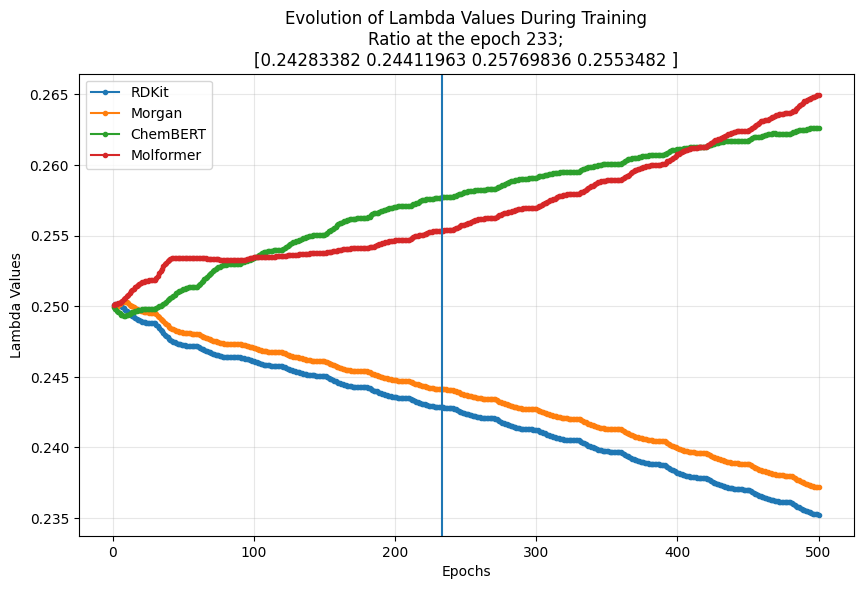

In [29]:
# Convert list of lambdas to numpy array for easier plotting
lambdas_array = np.array(train_lambdas)  # shape: [n_epochs, 4, 1]
lambdas_array = lambdas_array.squeeze()  # shape: [n_epochs, 4]

plt.figure(figsize=(10, 6))
epochs = range(1, len(train_lambdas) + 1)

# Plot each lambda
Ls = ['RDKit', 'Morgan', 'ChemBERT', 'Molformer']
for i in range(4):
    plt.plot(epochs, lambdas_array[:, i], label=Ls[i], marker='.')

plt.xlabel('Epochs')
plt.ylabel('Lambda Values')
plt.title(f'Evolution of Lambda Values During Training\nRatio at the epoch {val_aurocs_best_epoch+1};\n{lambdas_array[val_aurocs_best_epoch]}')
plt.axvline(val_aurocs_best_epoch+1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()